Imports

In [39]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.insert(0,'../')
from model_functions import *
from environment import env
config = env.env()

#Import Models
import model_functions.tfidf_model
import model_functions.spacy_model
import model_functions.nltk_model
import model_functions.get_context

In [79]:
import model_functions.tfidf_model

In [78]:
.03*30145/200

4.52175

Test Data

In [40]:
test_data = pd.read_csv('../02_nps_api_data/testing_queries.csv')
test_data.columns = ['query', 'intent', 'endpoint', 'parkcode']
test_data.head()

,query,intent,endpoint,parkcode
0,Give me information on Abraham Lincoln Birthpl...,description,parks,abli
1,What is Abraham Lincoln Birthplace National Hi...,description,parks,abli
2,Can you describe Abraham Lincoln Birthplace Na...,description,parks,abli
3,Give me information on Abraham Lincoln Birthpl...,description,parks,abli
4,Give me information on Acadia National Park,description,parks,acad


In [41]:
len(test_data)

30144

In [42]:
test_data = test_data.sample(100, random_state=10)
len(test_data)

100

Models

In [47]:
spacy_model = spacy_model_functions #from spacy_model.py
nltk_model = nltk_model_functions #from nltk_model.py
tfidf_model = tfidf_model #from nltk_model.py
gpt_model = nps_model_functions #from nps_model_functions.py

models = {'gpt': gpt_model,
          'spacy': spacy_model, 
          'nltk' : nltk_model,
          'tfidf': tfidf_model,
          }

Test Output

In [44]:
def test_output(query, models):
    for model in models:
        start = time.time()
        endpoint, park_code, intent = models[model].get_params(query)
        stop = time.time()
        duration = stop-start
        print(model, ':', endpoint, park_code, intent, round(duration,3), 'sec')

In [45]:
query = 'What state is Green Springs in?'
test_output(query, models)

gpt : parks grsp state 5.594 sec
spacy : parks grsp state 0.076 sec
nltk : parks grsp state 0.035 sec
tfidf : parks grsp state 0.034 sec


In [16]:
query = 'List the amenities at Zion'
test_output(query, models)

gpt : amenities zion amenities 1.928 sec
spacy : parks None other 0.014 sec
nltk : parks None other 0.044 sec
tfidf : amenities zion amenities 0.017 sec


In [17]:
query = 'What is the fee for Yosemite?'
test_output(query, models)

gpt : fees yose feespass 2.142 sec
spacy : parks None other 0.015 sec
nltk : parks None other 0.048 sec
tfidf : feespasses yose feespass 0.016 sec


In [5]:
query = 'What activities are at canyonlands?'
test_output(query, models)

gpt : events cany events 1.757 sec
spacy : parks None other 0.02 sec
nltk : parks None other 0.044 sec
tfidf : events cany events 0.017 sec


In [6]:
query = 'What can you do at canyonlands?'
test_output(query, models)

gpt : amenities cany feespass 2.144 sec
spacy : parks None other 0.015 sec
nltk : parks None other 0.043 sec
tfidf : alerts cany alerts 0.017 sec


In [7]:
query = 'What alerts are at bryce?'
test_output(query, models)

gpt : alerts brca alerts 1.577 sec
spacy : parks None other 0.014 sec
nltk : parks None other 0.043 sec
tfidf : alerts brca alerts 0.021 sec


Create Test Output Data Frame

In [46]:
def create_test_data (query_df, models):
    """ Input is test data in a data frame with query, intent, endpoing, and parkcode
        Output is the test data frame with predicted intent, endpoint and parkcode
        for each model
    """
    for model in models:
        start = time.time()
        tempt_df = query_df.apply(lambda x: models[model].get_params(x['query']), result_type='expand', axis=1)
        tempt_df.columns = [f'{model}_endpoint', f'{model}_parkcode', f'{model}_intent']
        query_df = pd.concat([query_df, tempt_df], axis=1)
        query_df = query_df.fillna('none')
        stop = time.time()
        duration = stop-start
        print(model, ':', round(duration,3), 'secs')
    return query_df

In [48]:
test_data = create_test_data(test_data, models)
test_data.to_pickle('test_data.pkl')
#For 100:
#gpt : 162.155 secs - 184.938 secs
#spacy : 1.153 secs - 1.186 secs
#nltk : 3.227 secs - 2.969 secs
#tfidf : 1.712 secs - 1.706 secs

gpt : 184.938 secs
spacy : 1.186 secs
nltk : 2.969 secs
tfidf : 1.706 secs


In [50]:
test_data = pd.read_pickle('test_data.pkl')
test_data.head()

,query,intent,endpoint,parkcode,gpt_endpoint,gpt_parkcode,gpt_intent,spacy_endpoint,spacy_parkcode,spacy_intent,nltk_endpoint,nltk_parkcode,nltk_intent,tfidf_endpoint,tfidf_parkcode,tfidf_intent
30027,What is the admission to visit Washington Monu...,feespass,feespasses,wamo,fees,wamo,feespass,parks,wamo,other,parks,wamo,other,feespasses,wamo,feespass
27346,What are the fees for visiting Saint Paul's Ch...,feespass,feespasses,sapa,fees,sapa,feespass,parks,sapa,other,parks,sapa,other,feespasses,sapa,feespass
8373,Please provide the full name of Maine Acadian ...,fullname,parks,maac,parks,maac,fullname,parks,maac,other,parks,maac,other,parks,maac,fullname
3312,Give me information on Port Chicago Naval Maga...,description,parks,poch,parks,poch,description,parks,none,other,parks,none,other,parks,poch,description
14924,Give me any active alerts for Virgin Islands C...,alerts,alerts,vicr,alerts,vicr,alerts,parks,none,other,parks,none,other,alerts,vicr,alerts


Model Accuracy

In [51]:
metrics = ['intent', 'endpoint', 'parkcode']

In [52]:
def plot_accuracy(df, metric): 
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df[metric], palette='YlGn')
    #sns.barplot(x='RecreationVisits', y='Full_ParkName', data=df, palette='YlGn')
    plt.xlabel('API Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy on {metric.capitalize()}')
    plt.show()

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_32220/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


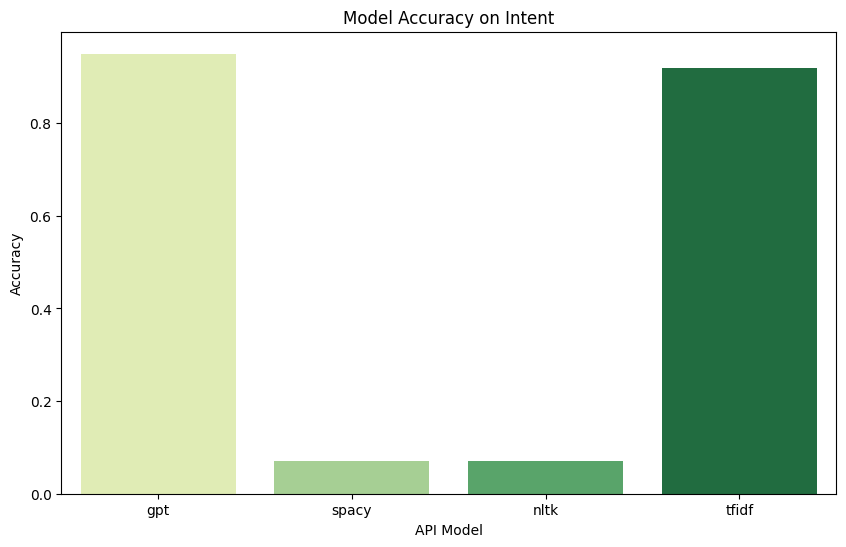

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_32220/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


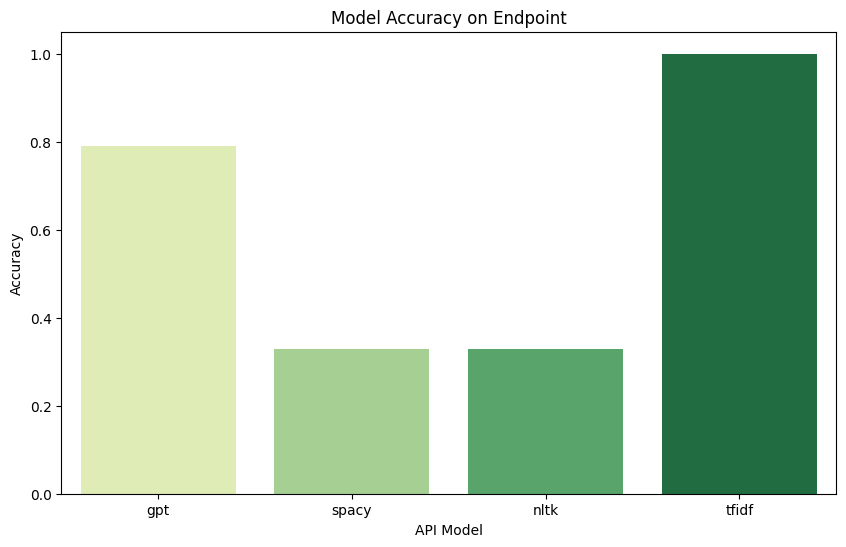

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_32220/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


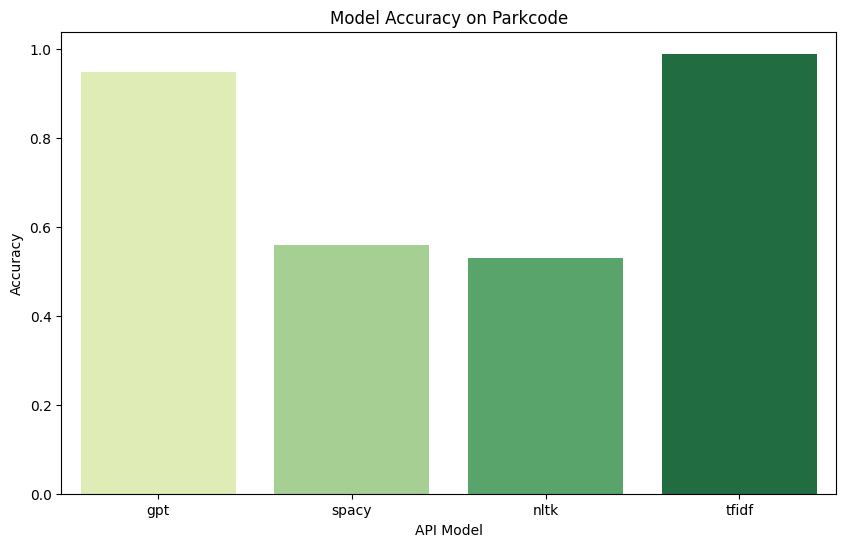

In [53]:
def model_accuracy (df, metrics, models):
    acc_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        for model in models:
            acc_df.loc[model,metric] = len(df.query(f'{metric}=={model}_{metric}'))/len(df)
        plot_accuracy(acc_df, metric)
    return acc_df

accuracy_df = model_accuracy(test_data, metrics, models)



In [54]:
accuracy_df

,intent,endpoint,parkcode
gpt,0.95,0.79,0.95
spacy,0.07,0.33,0.56
nltk,0.07,0.33,0.53
tfidf,0.92,1.0,0.99


Errors

In [70]:
def top_errors (df, metrics, models):
    errors_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        right = '&'.join([f'{metric}=={model}_{metric}' for model in models])
        wrong = '&'.join([f'{metric}!={model}_{metric}' for model in models])
        #errors_df.loc['total', metric] = len(df)
        errors_df.loc['all_right', metric] = len(df.query(right))
        errors_df.loc['all_wrong', metric] = len(df.query(wrong))
        for indx, model in enumerate(models):
            other_models = models[:indx]+models[indx+1:]
            right_model = '&'.join([f'{metric}=={model}_{metric}']+[f'{metric}!={mod}_{metric}' for mod in other_models])
            wrong_model = '&'.join([f'{metric}!={model}_{metric}']+[f'{metric}=={mod}_{metric}' for mod in other_models])
            errors_df.loc[f'only_{model}', metric] = len(df.query(right_model))
            errors_df.loc['_and_'.join([mod for mod in other_models])] = len(df.query(wrong_model))
    return errors_df

errors = top_errors(test_data, ['intent', 'endpoint', 'parkcode'], ['gpt', 'spacy', 'tfidf'])
errors

,intent,endpoint,parkcode
all_right,3,33,52
all_wrong,2,0,0
only_gpt,2,0,1
spacy_and_tfidf,4,4,4
only_spacy,0,0,0
gpt_and_tfidf,42,42,42
only_tfidf,3,21,1
gpt_and_spacy,0,0,0


In [71]:
def plot_errors(error_df):
    for metric in error_df.columns:
        colors = sns.color_palette('YlGn')[1:8]
        plt.figure(figsize=(10, 7))
        temp_df = error_df.query(f'{metric}>0')
        plt.pie(temp_df[metric], labels=temp_df.index, colors=colors, autopct='%1.1f%%')
        plt.title(f'Accurate Outcomes for {metric.capitalize()}')
        plt.show()

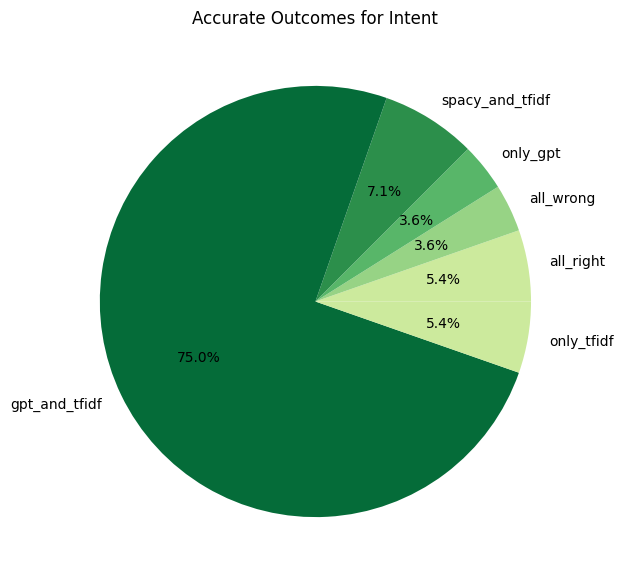

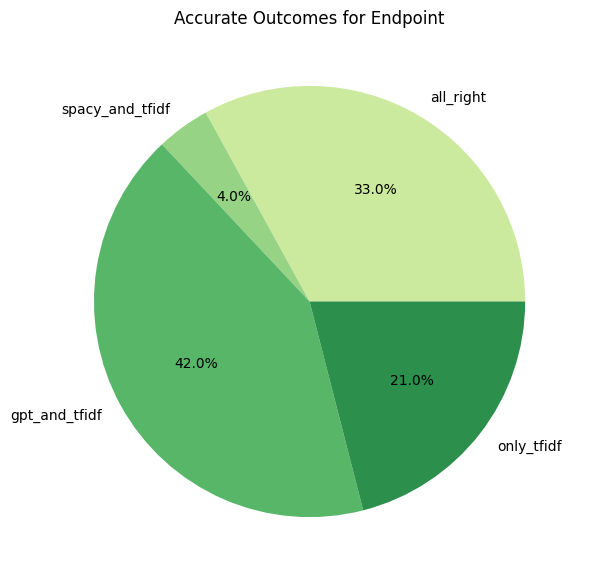

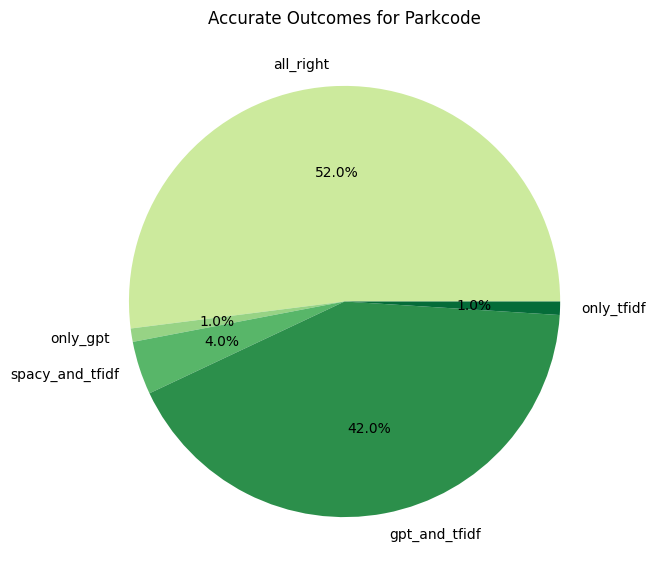

In [72]:
plot_errors(errors)

In [57]:
def find_wrong(df, metric, model):
    wrong = df.query(f'{metric}!={model}_{metric}')
    wrong = wrong[[metric, f'{model}_{metric}']].value_counts()

    return wrong

In [74]:
find_wrong(test_data, 'intent', 'gpt')

intent       gpt_intent
description  state         3
fullname     alerts        2
Name: count, dtype: int64

In [75]:
find_wrong(test_data, 'endpoint', 'gpt')

endpoint    gpt_endpoint
feespasses  fees            21
Name: count, dtype: int64

In [76]:
find_wrong(test_data, 'parkcode', 'gpt')

parkcode  gpt_parkcode
fomc      fom             2
brcr      brc             1
cakr      cak             1
cawo      caw             1
Name: count, dtype: int64

In [61]:
find_wrong(test_data, 'intent', 'spacy')

intent       spacy_intent
feespass     other           21
amenities    other           18
events       other           16
alerts       other           12
description  other           11
fullname     other           10
address      other            5
Name: count, dtype: int64

In [62]:
find_wrong(test_data, 'endpoint', 'spacy')


endpoint    spacy_endpoint
feespasses  parks             21
amenities   parks             18
events      parks             16
alerts      parks             12
Name: count, dtype: int64

In [63]:
find_wrong(test_data, 'parkcode', 'spacy')


parkcode  spacy_parkcode
ania      none              2
blri      none              2
noat      none              2
alpo      none              1
pull      none              1
lecl      none              1
ozar      none              1
peco      none              1
pinn      none              1
poch      none              1
pore      none              1
ston      none              1
sagu      none              1
klgo      none              1
ulsg      none              1
vicr      none              1
waba      none              1
waro      none              1
wica      none              1
wotr      none              1
kova      none              1
jeca      none              1
jotr      none              1
drto      none              1
boha      none              1
buis      none              1
caha      none              1
came      none              1
cowp      none              1
crmo      none              1
deto      none              1
ebla      none              1
amch      none 

In [64]:
find_wrong(test_data, 'intent', 'nltk')

intent       nltk_intent
feespass     other          21
amenities    other          18
events       other          16
alerts       other          12
description  other          11
fullname     other          10
address      other           5
Name: count, dtype: int64

In [65]:
find_wrong(test_data, 'endpoint', 'nltk')

endpoint    nltk_endpoint
feespasses  parks            21
amenities   parks            18
events      parks            16
alerts      parks            12
Name: count, dtype: int64

In [66]:
find_wrong(test_data, 'parkcode', 'nltk')

parkcode  nltk_parkcode
ania      none             2
blri      none             2
noat      none             2
alpo      none             1
sagu      none             1
ozar      none             1
peco      none             1
pinn      none             1
poch      none             1
pore      none             1
pull      none             1
saan      saga             1
sitk      saga             1
sajh      saga             1
kova      none             1
ston      none             1
tuma      saga             1
vicr      none             1
waba      none             1
waro      none             1
wica      none             1
wotr      none             1
lecl      none             1
klgo      none             1
amch      none             1
jotr      none             1
boha      none             1
buis      none             1
caha      none             1
came      none             1
cowp      none             1
crmo      none             1
deto      none             1
drto      none     

In [67]:
find_wrong(test_data, 'intent', 'tfidf')

intent       tfidf_intent
state        description     4
description  fullname        2
fullname     description     2
Name: count, dtype: int64

In [68]:
find_wrong(test_data, 'parkcode', 'tfidf')

parkcode  tfidf_parkcode
pinn      lyba              1
Name: count, dtype: int64

In [69]:
find_wrong(test_data, 'endpoint', 'tfidf')

Series([], Name: count, dtype: int64)